<a href="https://colab.research.google.com/github/shakib68/NYC-taxi-capstone/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

**Independent Variables**

id — a unique identifier for each trip

vendor_id — a code indicating the provider associated with the trip record

pickup_datetime — date and time when the meter was engaged

dropoff_datetime — date and time when the meter was disengaged

passenger_count — the number of passengers in the vehicle (driver entered value)

pickup_longitude — the longitude where the meter was engaged

pickup_latitude — the latitude where the meter was engaged

dropoff_longitude — the longitude where the meter was disengaged

dropoff_latitude — the latitude where the meter was disengaged distance:distance covered speed ; speed calculated

store_and_fwd_flag — This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server — Y=store and forward; N=not a store and forward trip.

**trip_duration** = dependent variable

**Importing  libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading data**

In [3]:
df=pd.read_csv("/content/drive/MyDrive/AlmaBetter/capstone project 2/Copy of NYC Taxi Data.csv")


In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


**Checking Datatype in our Dataset**

In [6]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [7]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
df.shape

(1458644, 11)

**Checking missing value**

In [9]:
# Missing Value Count Function
def show_missing():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df[show_missing()].isnull().sum().sort_values(ascending = False)/len(df)*100,2))

Missing Data Count
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Series([], dtype: float64)


**Here you can see there is no missing value in our dataset, So will proceed for solution and analysis**

**Importing geopy library to calculate distance**


In [10]:
from geopy.distance import great_circle

**Calculte distance betwee pickup and dropoff points**

In [11]:
#Calculte distance betwee pickup and dropoff points
def distance_cal(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [12]:
# Calculating distance for each trip
df['distance'] = df.apply(lambda df: distance_cal(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'] ), axis=1)


In [13]:
df['distance']

0          1.498523
1          1.805510
2          6.385108
3          1.485501
4          1.188590
             ...   
1458639    1.225082
1458640    6.049844
1458641    7.824617
1458642    1.092565
1458643    1.134044
Name: distance, Length: 1458644, dtype: float64

**converting it to datetime**

In [14]:
#convert it to datetime
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

In [15]:

df['pickup_day_no']=df['pickup_datetime'].dt.weekday
df['dropoff_day_no']=df['dropoff_datetime'].dt.weekday
df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

In [16]:
df.shape

(1458644, 18)

**Checking for outlier in column trip duration**

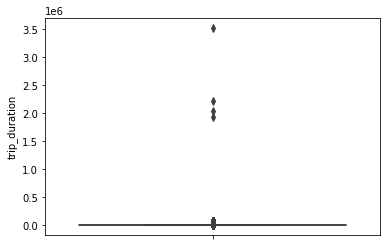

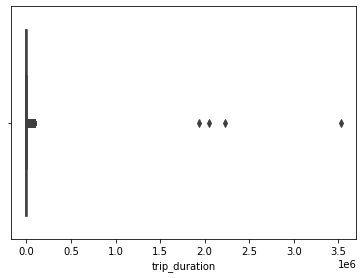

In [17]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y=df['trip_duration'])
plt.show()
columns=['trip_duration']
n = 1
plt.figure(figsize=(20,15))

for column in columns:
  plt.subplot(4,4,n)
  n = n+1
  sns.boxplot(df[column])
  plt.tight_layout()

**You can see that there are some outliers in dataset so we will try to fin 0-100 percentile value  to find a the correct percentile value for removal of outliers**

In [18]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


0 percentile value is 1
10 percentile value is 245
20 percentile value is 348
30 percentile value is 446
40 percentile value is 548
50 percentile value is 662
60 percentile value is 798
70 percentile value is 968
80 percentile value is 1208
90 percentile value is 1634
100 percentile value is  3526282


**We can see that the value of outlier is in the range from 90 to 100 percentile but we do not  know exactly so we do some more step from 90-100**

In [19]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 1634
91 percentile value is 1703
92 percentile value is 1780
93 percentile value is 1869
94 percentile value is 1975
95 percentile value is 2104
96 percentile value is 2273
97 percentile value is 2497
98 percentile value is 2829
99 percentile value is 3440
100 percentile value is  3526282


In [20]:
#calculating 99-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(99.0,100.0,10 ,endpoint=False):
    var =df["trip_duration"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])


99.0 percentile value is 3440
99.1 percentile value is 3540
99.2 percentile value is 3652
99.3 percentile value is 3782
99.4 percentile value is 3942
99.5 percentile value is 4139
99.6 percentile value is 4403
99.7 percentile value is 4765
99.8 percentile value is 5552
99.9 percentile value is 85129
100 percentile value is  3526282


**From here we can set the value for trip duration less than 18000 ,otherwise all the values>18000 will be treated as outlier becouse more than 5 hour of taxi trip is not feasible**

In [21]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,max(df.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446313
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

In [22]:
df = df[df.trip_duration <= 18000]

**Oulier in distance column**

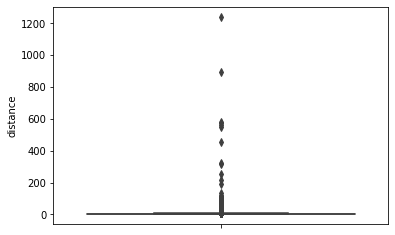

In [23]:

sns.boxplot(y=df['distance'])
plt.show()

**we can see that there are some outlier**

In [24]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.7924562818659672
20 percentile value is 1.089497960376577
30 percentile value is 1.3797536152657544
40 percentile value is 1.7060766803437428
50 percentile value is 2.093306827438099
60 percentile value is 2.5968141567820595
70 percentile value is 3.3361165210061983
80 percentile value is 4.618216034873399
90 percentile value is 7.62749463829288
100 percentile value is  1240.9104296218293


**Will try to find 90-100 percentile value to get clear value**

In [25]:
#calculating 90-100th percentile to find a the correct percentile value for removal of outliers
for i in range(90,100):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 7.62749463829288
91 percentile value is 8.252245356170992
92 percentile value is 8.88433307801906
93 percentile value is 9.454162672228154
94 percentile value is 10.077606337837588
95 percentile value is 11.012925939000201
96 percentile value is 12.807934490534205
97 percentile value is 15.403320357695033
98 percentile value is 19.362263611693667
99 percentile value is 20.785387862712486
100 percentile value is  1240.9104296218293


**have to see the percentile from 99-100 to get more clear picture**

In [26]:
#calculating 99-100th percentile to find a the correct percentile value for removal of outliers
for i in np.linspace(99.0,100.0,10 ,endpoint=False):
    var =df["distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 20.785387862712486
99.1 percentile value is 20.919524006820765
99.2 percentile value is 21.04985478020312
99.3 percentile value is 21.185837864999066
99.4 percentile value is 21.36475476479681
99.5 percentile value is 21.555802225468828
99.6 percentile value is 21.829646912627005
99.7 percentile value is 22.261440544315704
99.8 percentile value is 22.888391922719975
99.9 percentile value is 24.7552375528992
100 percentile value is  1240.9104296218293


In [27]:
df['distance'].value_counts()


0.000000    5894
0.000424      45
0.000424      43
0.000424      35
0.000424      22
            ... 
0.434274       1
3.809274       1
0.563330       1
5.925436       1
1.134044       1
Name: distance, Length: 1450293, dtype: int64

**We can take value as 30 becouse 99.9 percentile value are less than it**

In [28]:
df=df[df['distance']<30]

**We will only keep those observation whose distance is greater than 0 ,as equal to zero will be a false entry**

In [29]:
df=df[df['distance']!=0]


In [30]:
df['distance'].value_counts()


0.000424    45
0.000424    43
0.000424    35
0.000424    22
0.000424    21
            ..
3.343165     1
4.218078     1
8.860892     1
1.498127     1
1.134044     1
Name: distance, Length: 1449723, dtype: int64

**Passenger column outlier treatment**

In [31]:
df.passenger_count.value_counts()


1    1027680
2     209112
5      77578
3      59559
6      47926
4      28200
0         51
7          2
8          1
Name: passenger_count, dtype: int64

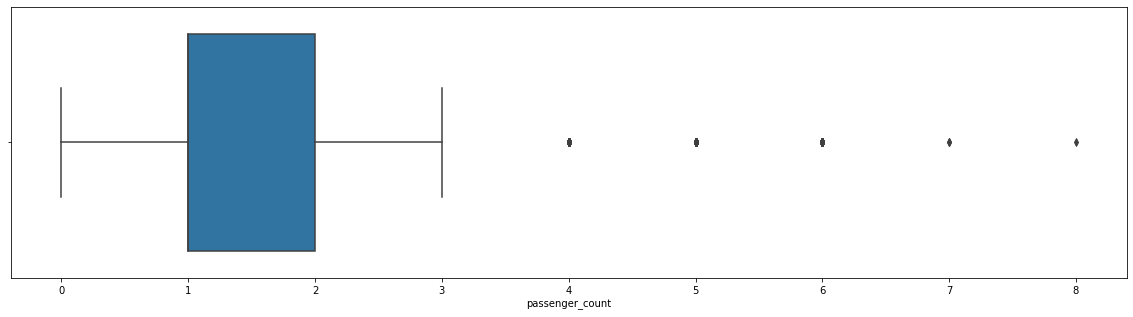

In [32]:
plt.figure(figsize = (20,5))
sns.boxplot(df.passenger_count)
plt.show()

**we can see that there are some outlier**

There are some trips with 0 passenger count.

Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency

Most of trip consist of passenger either 1 or 2

So we would replace the 0 passenger count with 1.

In [33]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)


**Also, we will remove the records with passenger count > 7, 8 or 9 as they are extreme values and looks very odd to be ocupied in a taxi.**

In [34]:
df = df[df.passenger_count <= 6]

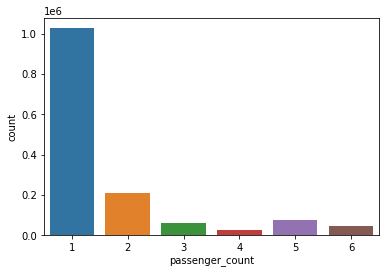

In [35]:
sns.countplot(x='passenger_count',data=df)





**Outlier in speed column**

#EDA

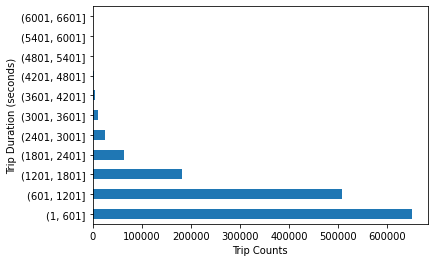

In [37]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


**hourly Analysis**

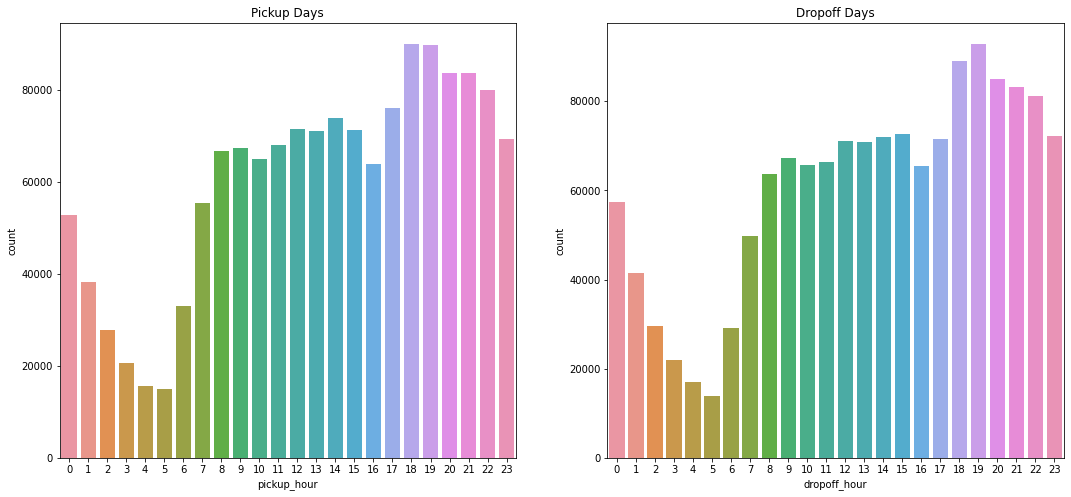

In [38]:
fig, axs = plt.subplots(1,2, figsize=(18, 8))
axs[0].set_title('Pickup Days')


sns.countplot(x=df['pickup_hour'],ax=axs[0])

axs[1].set_title('Dropoff Days')
sns.countplot(x=df['dropoff_hour'],ax=axs[1])

**Monthly Analysis**

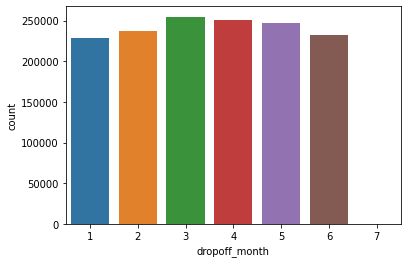

In [39]:
sns.countplot(df['dropoff_month'])


**Setting a time cycle of a day **

**Based on vendor id**

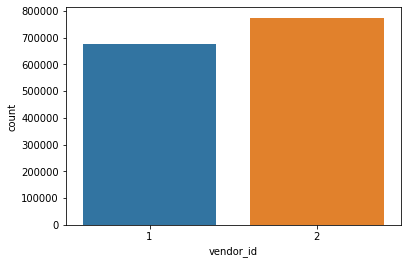

In [40]:
sns.countplot(x='vendor_id',data=df)


**Let's visualize the relationship between Distance covered and respective trip duration.**

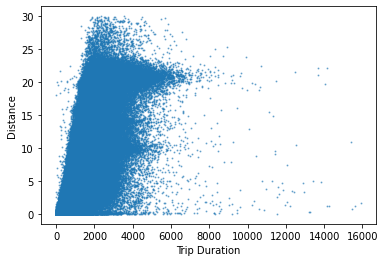

In [41]:
plt.scatter(df.trip_duration, df.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

** Correlation heatmap**

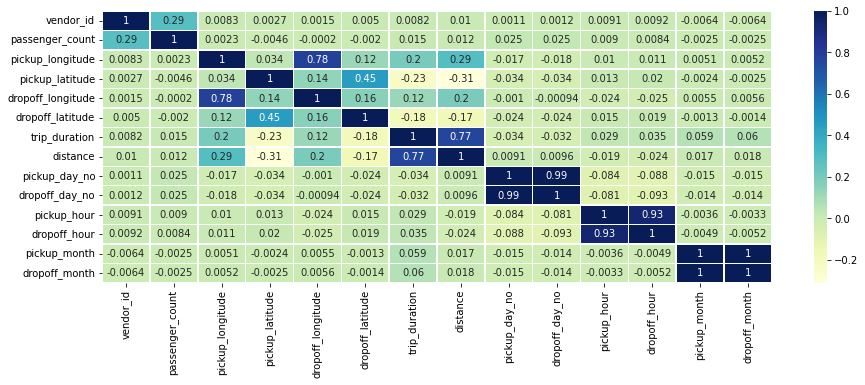

In [42]:
fig, ax = plt.subplots(figsize=(15,5))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=.5)

  #
# displaying heatmap
plt.show()

**Done with data treatment and analysis ,will proceed to split the data in train and testthen will apply supervised ML model**

#splitting data into train and test

In [43]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'pickup_day_no', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'pickup_month', 'dropoff_month'],
      dtype='object')

**We will create some dummy variable for categorical variable**

In [44]:
x=df.drop(['trip_duration','id','pickup_datetime','dropoff_datetime'],axis=1)
y=df['trip_duration']
x=pd.get_dummies(x,'store_and_fwd_flag',drop_first=True)

In [45]:
df.store_and_fwd_flag.value_counts(normalize=True)

N    0.994504
Y    0.005496
Name: store_and_fwd_flag, dtype: float64

In [46]:
# Normalising Predictors and creating new dataframe

from sklearn.preprocessing import StandardScaler

cols = x.columns

ss = StandardScaler()

x = ss.fit_transform(x)
x = pd.DataFrame(x, columns=cols)
x.head()
y

0           455
1           663
2          2124
3           429
4           435
           ... 
1458639     778
1458640     655
1458641     764
1458642     373
1458643     198
Name: trip_duration, Length: 1450106, dtype: int64

In [47]:
x=pd.get_dummies(x,columns=['vendor_id', 
       'passenger_count',
       'pickup_day_no', 'dropoff_day_no', 'pickup_hour', 'dropoff_hour',
       'pickup_month', 'dropoff_month'],drop_first=True)

In [48]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2)


# Using Linear regression ML model

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [49]:
reg = LinearRegression().fit(x_train, y_train)


In [56]:
reg.coef_

array([-6.62136212e+01,  1.85496168e+01, -5.03144421e+01, -3.86448583e+01,
        5.28929275e+02,  1.63398263e+00, -9.32974606e-01,  2.06385032e+01,
        2.59053436e+01,  3.85778463e+01,  4.70914316e+00,  8.12040415e+00,
        1.95734509e+02,  3.60505108e+02,  4.49558502e+02,  3.68025847e+02,
        1.01396405e+02, -2.20201411e+02, -1.23855142e+02, -2.63677774e+02,
       -3.44003109e+02, -2.82171466e+02, -9.43751135e+01,  1.65378855e+02,
        6.12495280e+01,  1.97257250e+02,  4.48595965e+02,  9.21322765e+02,
        1.68735195e+03,  2.31324270e+03,  2.53843986e+03,  2.45108360e+03,
        2.25982095e+03,  2.09297579e+03,  1.95025023e+03,  1.79282567e+03,
        1.62669446e+03,  1.47217326e+03,  1.24272011e+03,  9.35512722e+02,
        5.97712294e+02,  3.10687759e+02,  1.18842758e+02,  3.68849254e+01,
        1.85925472e+01, -1.79277348e+00, -5.44872211e+01, -7.54825005e+01,
       -2.20529563e+02, -4.54528765e+02, -9.46959270e+02, -1.80457229e+03,
       -2.44054832e+03, -

In [51]:
pred_train =reg.predict(x_train)

In [53]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(pred_train,y_train)


0.41651207751696456

In [54]:
pred_test = reg.predict(x_test)

**accuracy**

In [59]:
r2_score(y_train, pred_train)

0.6556225517136598

# Random Forest Regressor (Bagging)

In [60]:
# import random forest 
from sklearn.ensemble import RandomForestRegressor

In [61]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [62]:
y_pred = regr1.predict(x_train)
mean_absolute_percentage_error(y_pred, y_train)

0.21453780962258603

**accuracy**

In [63]:
r2_score(y_train, y_pred)

0.8476796058778031

#XGboost ML model

In [64]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,

 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,)
xgb_model.fit(x_train, y_train)

[13:53:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_xgb=xgb_model.predict(x_train)
mean_absolute_percentage_error(y_pred_xgb,y_train)